# Consumption Responses
- This notebook studies how households changed their consumption in response to the Mexican Peso Crisis of 1994
- I measure this using the 1994 and 1996 datasets
- The primarly measure is the *consumption-income elasticity*: the percentage change in consumption divided by the percentage change in income
- If a household has an elasticity near or above one, it implies they were not able to protect their consumption from their decline in income
- I study the interaction of the *consumption-income elasticity* and income. I bin households according to their *income decile* and study the elasticity of each decile.

## Results
- The lowest income decile displayed larger consumption declines than all other income deciles.
- Households cut back more on clothing, housing, and health goods.
- Households cut back less on food, transportation, and personal items.

The intuition? Food, transportation, and personal items are essential, whereas purchases of clothing, housing, and transportation can be delayed during a recession.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os; home = os.path.expanduser('~')

processed = home + '/Dropbox/data/mexico_enigh/processed2'
fig = home + '/Github/household-consumption/fig/'
os.chdir(processed)
df = pd.read_csv('data.csv')
os.chdir(fig)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20399 entries, 0 to 20398
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   financial_income            20399 non-null  float64
 1   consumption_health          20399 non-null  float64
 2   income_transfers            20399 non-null  float64
 3   hhid                        20399 non-null  int64  
 4   consumption_food            20399 non-null  float64
 5   location                    20399 non-null  object 
 6   consumption_education       20399 non-null  float64
 7   income_total                20399 non-null  float64
 8   income_current              20399 non-null  float64
 9   consumption_house           20399 non-null  float64
 10  consumption_current         20399 non-null  float64
 11  income_business             20399 non-null  float64
 12  consumption_clothing        20399 non-null  float64
 13  consumption_personal        203

In [43]:
# 'post' is an indicator for the recession, when we expect consumption and income to decline
df['post'] = df['Y'] == 1996

# Income Deciles
1. This section computes the income decile within each year

In [44]:
import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

20399


# Dummy Variables
1. This section creates dummy variables for sex, education, location, and income decile
2. For each, we drop the first indicator to avoid colinearity

In [45]:
dummies ={}
dummies_names = []

to_dummies = ['sex', 'education', 'location_size', 'decile']

for var in to_dummies:
    print('Making dummies for', var)
    # create dummies
    dummies[var] = pd.get_dummies(df[var], drop_first=True, prefix=var)

    # store dummy names to access for regression
    dummies_names += list(dummies[var].columns)


Making dummies for sex
Making dummies for education
Making dummies for location_size
Making dummies for decile


In [46]:
# concatenate dummy values to main dataframe
for data in dummies.values():
    df = pd.concat([df, data], axis=1)

# Interaction Dummy Variables
1. This section creates interactions with the recession and education, sex, and income decile

In [47]:
# education x post
df['post_education'] = df['post'] * (pd.Categorical(df.education).codes + 1)
C_post_education = pd.get_dummies(df['post_education'], prefix='post_education', drop_first=True)
C_post_education = C_post_education.drop(columns='post_education_1')
dummies_names += list(C_post_education.columns)
df = pd.concat([df, C_post_education], axis=1)

In [48]:
# sex x post
df['post_sex'] = df['post'] * (pd.Categorical(df.sex).codes + 1)
C_post_sex = pd.get_dummies(df['post_sex'], prefix='post_sex', drop_first=True)
C_post_sex = C_post_sex.drop(columns='post_sex_1')
dummies_names += list(C_post_sex.columns)
df = pd.concat([df, C_post_sex], axis=1)

### Income Decile x Post
1. This variable interacts a household's income decile with POST, the recession
2. This captures the heterogeneous effects of POST on each income decile, for different measures such as income or consumption 

In [49]:
df['post_decile'] = df['post'] * df['decile']
C_post_decile = pd.get_dummies(df['post_decile'], prefix='post_decile')
C_post_decile = C_post_decile.drop(columns=['post_decile_0'])
dummies_names += list(C_post_decile.columns)
df = pd.concat([df, C_post_decile], axis=1)

In [50]:
continuous = ['age', 'age_sq']
X_col = continuous + dummies_names
X_col

['age',
 'age_sq',
 'sex_Male',
 'education_Low',
 'education_Medium',
 'location_size_2',
 'location_size_3',
 'location_size_4',
 'decile_2',
 'decile_3',
 'decile_4',
 'decile_5',
 'decile_6',
 'decile_7',
 'decile_8',
 'decile_9',
 'decile_10',
 'post_education_2',
 'post_education_3',
 'post_sex_2',
 'post_decile_1',
 'post_decile_2',
 'post_decile_3',
 'post_decile_4',
 'post_decile_5',
 'post_decile_6',
 'post_decile_7',
 'post_decile_8',
 'post_decile_9',
 'post_decile_10']

In [51]:
nboot = 2000
coef_income = np.ones((nboot, 10), dtype=np.float64)
coef_consumption = np.ones((nboot, 10), dtype=np.float64)

In [52]:
from sklearn.linear_model import LinearRegression

# build linear regression model
linear = LinearRegression()

def bootstrap_regression(df, X_col, Y_col, income_measure=None, weight='weight', nboot=50):
    print('Running ', nboot, ' bootstrap replications')

    # nboot x 10 array for income_decile coefficients for each bootstrap draw
    coef_consumption = np.ones((nboot, 10), dtype=np.float64)

    # optional array for income effects
    if income_measure is not None:
        coef_income = np.ones((nboot, 10), dtype=np.float64)
    else:
        coef_income = None

    for boot in np.arange(nboot):
        # form bootstrap dataset, weighted by sample weights
        df_boot = df.sample(len(df), replace=True, weights=df[weight], axis=0)

        # get X and Y data
        X = df_boot[X_col]
        Y = df_boot[Y_col]

        # fit model
        linear.fit(X, Y)

        # extract income decile coefficients, LAST in the list of regressors
        coef_consumption[boot, :] = np.squeeze(linear.coef_)[-10:]

        if income_measure is not None:
            Y_income = df_boot[income_measure]

            linear.fit(X, Y_income)
            coef_income[boot, :] = np.squeeze(linear.coef_)[-10:]
    return coef_consumption, coef_income

In [53]:
coef_consumption, coef_income = bootstrap_regression(df, X_col, 'log_consumption', income_measure='log_income')

Running  50  bootstrap replications


In [54]:
# consumption types to be examined separately
consumption_types = ['consumption_current',
                     'consumption_food',
                     'consumption_clothing',
                     'consumption_personal',
                     'consumption_health',
                     'consumption_house',
                     'consumption_transportation'
                     ]

In [55]:
# storage for response of consumption
dconsumption = {}

# storage for response of income
dincome = {}

# storage for elasticity: dconsumption / dincome
elasticities = {}

# for each consumption_type
for consumption_type in consumption_types:

    dconsumption[consumption_type] = {}
    dincome[consumption_type] = {}
    elasticities[consumption_type] = {}

    # take logs of consumption so we are measuring the percentage change
    df['log_' + consumption_type] = np.log(df[consumption_type])
    dfin = df[df[consumption_type] > 0]

    # get bootstrap regression estimates of log consumption
    # use basic log_income measure that measures labor income
    coef_consumption, coef_income = bootstrap_regression(dfin, X_col, 'log_'+consumption_type, income_measure='log_income')

    # for each bootstrap sample x coefficient, the elasticity is the percentage change in consumption 
    # divided by the percentage change in income
    elasticity = coef_consumption / coef_income

    # collect mean
    dconsumption[consumption_type]['mean'] = np.mean(coef_consumption, axis=0)
    dincome[consumption_type]['mean'] = np.mean(coef_income, axis=0)
    elasticities[consumption_type]['mean'] = np.mean(elasticity, axis=0)

    # collect 90th percentile
    dconsumption[consumption_type]['q90'] = np.quantile(coef_consumption, 0.90, axis=0)
    dincome[consumption_type]['q90'] = np.quantile(coef_income, 0.90, axis=0)
    elasticities[consumption_type]['q90'] = np.quantile(elasticity, 0.90, axis=0)

    # collect 10th percentile
    dconsumption[consumption_type]['q10'] = np.quantile(coef_consumption, 0.10, axis=0)
    dincome[consumption_type]['q10'] = np.quantile(coef_income, 0.10, axis=0)
    elasticities[consumption_type]['q10'] = np.quantile(elasticity, 0.10, axis=0)

Running  50  bootstrap replications


/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running  50  bootstrap replications


/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running  50  bootstrap replications


/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running  50  bootstrap replications


/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running  50  bootstrap replications


/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running  50  bootstrap replications


/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Running  50  bootstrap replications


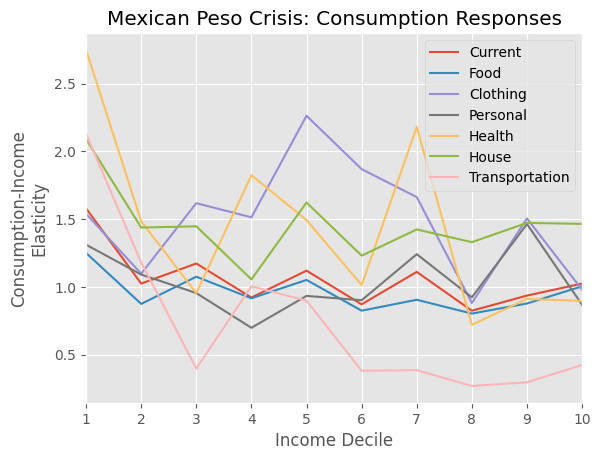

In [65]:
deciles = np.arange(1, 11)
plt.title('Mexican Peso Crisis: Consumption Responses')
for consumption_type in consumption_types:
    label= consumption_type.replace('consumption_', '').title()
    plt.plot(deciles, elasticities[consumption_type]['mean'], label=label)
plt.ylabel('Consumption-Income\nElasticity')
plt.xlabel('Income Decile')
plt.margins(x=0)
plt.legend();

### Responses: Percentage Change
- The below figure plots the percentage change in a consumption type for each income decile

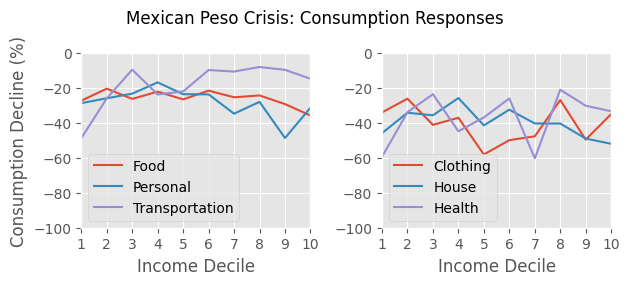

In [66]:
ymax = 0.00
ymin = -100

plt.suptitle('Mexican Peso Crisis: Consumption Responses')

plt.subplot(221)
for consumption_type in ['consumption_food', 'consumption_personal', 'consumption_transportation']:
    label= consumption_type.replace('consumption_', '').title()
    plt.plot(deciles, 100 * dconsumption[consumption_type]['mean'], label=label)
plt.legend()
plt.ylim(ymin, ymax)
plt.xlabel('Income Decile')
plt.xticks(deciles)
plt.margins(x=0)
plt.ylabel('Consumption Decline (%)')

plt.subplot(222)
for consumption_type in ['consumption_clothing', 'consumption_house', 'consumption_health']:
    label= consumption_type.replace('consumption_', '').title()
    plt.plot(deciles, 100 * dconsumption[consumption_type]['mean'], label=label)
plt.legend()
plt.ylim(ymin, ymax)
plt.xlabel('Income Decile')
plt.xticks(deciles);
plt.margins(x=0)

plt.tight_layout()
plt.savefig('../fig/mpc_percentchange_separate.png', dpi=300, bbox_inches='tight')

### Responses: Elasticities
- We can see that households have smaller responses (on average) for food, personal items, and transportation
- In contrast, households have large responses for clothing, housing, and health

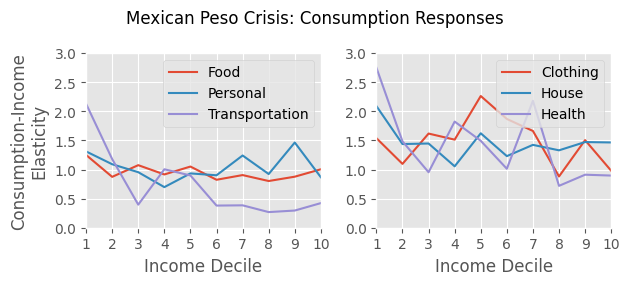

In [67]:
ymin = 0.00
ymax = 3.00
plt.suptitle('Mexican Peso Crisis: Consumption Responses')

plt.subplot(221)
for consumption_type in ['consumption_food', 'consumption_personal', 'consumption_transportation']:
    label= consumption_type.replace('consumption_', '').title()
    plt.plot(deciles, elasticities[consumption_type]['mean'], label=label)
plt.legend()
plt.ylim(ymin, ymax)
plt.xlabel('Income Decile')
plt.xticks(deciles)
plt.margins(x=0)
plt.ylabel('Consumption-Income\nElasticity')

plt.subplot(222)
for consumption_type in ['consumption_clothing', 'consumption_house', 'consumption_health']:
    label= consumption_type.replace('consumption_', '').title()
    plt.plot(deciles, elasticities[consumption_type]['mean'], label=label)

plt.legend()
plt.xlabel('Income Decile')
plt.xticks(deciles);
plt.margins(x=0)
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.savefig('../fig/mpc_elasticity_separate.png', dpi=300, bbox_inches='tight')

## Nondurable Consumption
- This section studies the response of a measure of 'nondurable' consumption, which includes clothing, food, and personal items

In [59]:
coef_consumption = np.ones((nboot, 10), dtype=np.float64)
coef_income = np.ones((nboot, 10), dtype=np.float64)

for boot in np.arange(nboot):
    df_boot = df.sample(len(df), replace=True, weights=df['weight'], axis=0)
    X = df_boot[X_col]
    Y_income = df_boot[['log_income']]
    Y_consumption = df_boot[['log_consumption']]

    linear.fit(X, Y_income)
    coef_income[boot, :] = np.squeeze(linear.coef_)[-10:]

    linear.fit(X, Y_consumption)
    coef_consumption[boot, :] = np.squeeze(linear.coef_)[-10:]

In [60]:
coef_elasticity = coef_consumption / coef_income

In [61]:
coef_income_q10 = np.quantile(coef_income, q=0.10, axis=0)
coef_income_q90 = np.quantile(coef_income, q=0.90, axis=0)
coef_income_mean = np.mean(coef_income, axis=0)

coef_consumption_q10 = np.quantile(coef_consumption, q=0.10, axis=0)
coef_consumption_q90 = np.quantile(coef_consumption, q=0.90, axis=0)
coef_consumption_mean = np.mean(coef_consumption, axis=0)

coef_elasticity_q10 = np.quantile(coef_elasticity, q=0.10, axis=0)
coef_elasticity_q90 = np.quantile(coef_elasticity, q=0.90, axis=0)
coef_elasticity_mean = np.mean(coef_elasticity, axis=0)

### Income and Nondurable Consumption Responses
- This figure plots the responses of income and consumption for each income decile.
- We can see that high income households suffered worse income losses than low income households, by about 15%.
- In percentage terms, low income households featured smaller consumption declines.

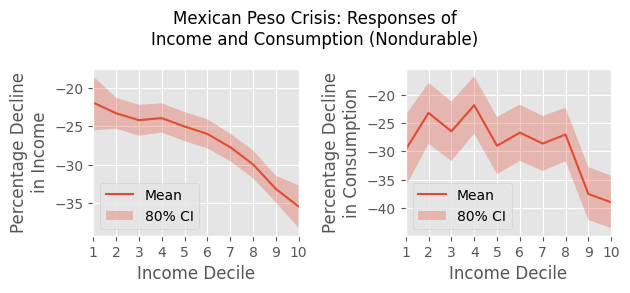

In [75]:
deciles = np.arange(1, 11)
plt.suptitle('Mexican Peso Crisis: Responses of\nIncome and Consumption (Nondurable)')

plt.subplot(221)
plt.plot(deciles, 100*coef_income_mean, label='Mean')
plt.fill_between(deciles, 100*coef_income_q10, 100*coef_income_q90, alpha=0.3, label='80% CI')
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Income')
plt.margins(x=0)
plt.legend(loc='lower left')

plt.subplot(222)
plt.plot(deciles, 100*coef_consumption_mean, label='Mean')
plt.fill_between(deciles, 100*coef_consumption_q10, 100*coef_consumption_q90, alpha=0.3, label='80% CI')
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Consumption')
plt.margins(x=0)
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../fig/mpc_percentchange_nondurable.png', dpi=300, bbox_inches='tight')

### Nondurable Consumption Elasticity
- This figure plots the *elasticity* of consumption relative to income.
- Here we can see the elasticity is higher for low income households.
- That is, relative to their decline in income, low income households featured a larger consumption response.
- Low income households feature a smaller overall response because they had a smaller decline in income.

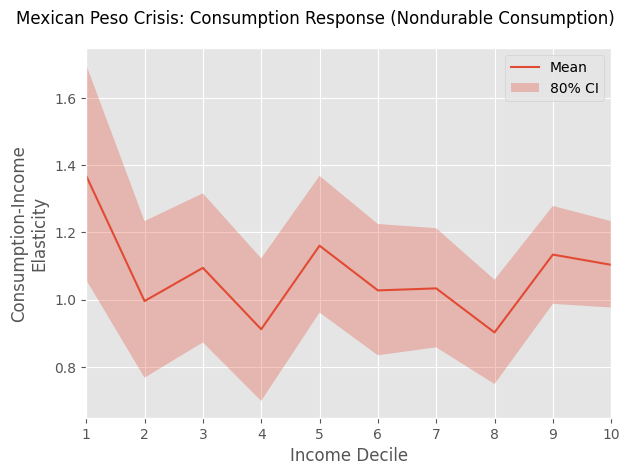

In [76]:
plt.suptitle('Mexican Peso Crisis: Consumption Response (Nondurable Consumption)')
plt.plot(deciles, coef_elasticity_mean, label='Mean')
plt.fill_between(deciles, coef_elasticity_q10, coef_elasticity_q90, alpha=0.3, label='80% CI')
plt.legend()
plt.ylabel('Consumption-Income\nElasticity')

plt.xticks(deciles)
plt.xlabel('Income Decile')

plt.margins(x=0)

plt.tight_layout()
plt.savefig('../fig/mpc_elasticity_nondurable.png', dpi=300, bbox_inches='tight')